In [2]:
# Basic import
import os
import sys
import json
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Helper function
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def read_json(src_path):
    with open(src_path, 'r') as json_file:
        data = json.load(json_file)
    return data

def write_json(data,dst_path):
    with open(dst_path, 'w') as outfile:
        json.dump(data, outfile)

In [17]:
ROOT = './2018SplitTrailers/'
len(os.listdir(ROOT))

1405

In [18]:
import cv2
import imutils
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

In [19]:
def first_nonzero(arr, axis, invalid_val=-1, rev = False):
    if rev:
        mask = np.flip(arr)!=0
    else:
        mask = arr!=0
    
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def nonzero(arr): # horizontal axis=0 # vertical axis=1
    upper = first_nonzero(arr, axis = 0, invalid_val=0)
    lower = first_nonzero(arr, axis = 0, rev = True, invalid_val=0)
#     print(not np.array_equal(upper, lower))
#     print(upper, lower)
    return np.append(upper, lower)

def count_mode(arr):
    #bincount（）：統計非負整數的個數，不能統計浮點數
    counts = np.bincount(arr)
    #返回眾數
    return np.argmax(counts)

In [ ]:
crop_dict = {}
count = 0
for movie in os.listdir(ROOT):
    print(count, 'Running:', movie)
    
    # init
    li = []
    scaler = MinMaxScaler(feature_range=(0, 255), copy=True)
    
    # collect all middle frame in each scene
    for scene in os.listdir(ROOT + movie)[:20]:
        framePath = ROOT + movie + '/' + scene + '/frames/'
#         print(framePath, os.listdir(framePath))
        frameList = [int(name.split('.')[0]) for name in os.listdir(framePath)]
        frameList.sort()
#         print(frameList)
        keyframe = framePath + '/' + str(frameList[len(frameList)//2]) + '.jpg'
#         print(keyframe)
        
        # 讀取圖檔
        img = cv2.imread(keyframe)

        # 轉換至 HSV 色彩空間
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # 取出明度
        value = hsv[:,:,2]
        li.append(value)
    
    arr = np.asarray(li)
#     print(len(li), arr.shape)
    # sum up
    arr_sum = np.sum(arr, axis=0)
#     print(arr_sum.shape, 'Max:',np.max(arr_sum), 'Min:',np.min(arr_sum))
    
    # Mapping between 0 and 255
    scaler.fit(arr_sum)
    arr_norm = scaler.transform(arr_sum)
#     print(np.max(arr_norm), np.min(arr_norm))
    
    h = arr_norm.shape[0]
    w = arr_norm.shape[1]
    
    _, threshold = cv2.threshold(arr_norm, 50, 255, cv2.THRESH_BINARY)
#     print(np.unique(threshold)) # only 0 and 255
    
    nonz = nonzero(arr_norm)
    nonz_thresh = nonzero(threshold)
    
    mode = count_mode(nonz)
    mode_thresh = count_mode(nonz_thresh)
    
    print('Crop range:',mode, h - mode)
    crop_img = img[mode: h - mode, :] # horizontal
#     crop_img = img[:, mode: w - mode] # vertical
    
    print('Crop range:',mode_thresh, h - mode_thresh)
    crop_img_thresh = img[mode_thresh: h - mode_thresh, :] # horizontal
#     crop_img = img[:, mode_thresh: w - mode_thresh] # vertical
    
    plt.figure(figsize=(18,6))
    plt.subplot(131).set_title("Cropped"), plt.imshow(crop_img)
    plt.subplot(132).set_title("Cropped_thresh"), plt.imshow(crop_img_thresh)
    plt.subplot(133).set_title("Original"), plt.imshow(arr_norm)
    plt.show()
    
    # save crop dict
    crop_dict[movie] = mode_thresh
    count += 1
    print('====================================================================================================')

### Some dict problem

In [37]:
print(len(crop_dict))
print(type(crop_dict))
print(crop_dict)

33
<class 'dict'>
{'tt9635722': 0, 'tt9289116': 0, 'tt8999902': 11, 'tt8336974': 0, 'tt8529512': 156, 'tt8887736': 0, 'tt7318102': 156, 'tt8819182': 0, 'tt8580242': 160, 'tt8386758': 140, 'tt7809816': 96, 'tt7182950': 0, 'tt6211472': 144, 'tt9023136': 88, 'tt7125060': 44, 'tt9037262': 0, 'tt8973954': 186, 'tt9572670': 73, 'tt5960374': 28, 'tt9344042': 288, 'tt4542328': 80, 'tt8640242': 0, 'tt3211248': 88, 'tt7640194': 0, 'tt4883336': 92, 'tt8137788': 0, 'tt8685584': 0, 'tt8671600': 32, 'tt8434576': 304, 'tt6151592': 0, 'tt9204152': 145, 'tt4173184': 0, 'tt8942192': 76}


In [25]:
write_json(str(crop_dict), './json/crop_dict4Trailers_2018.json')

In [26]:
# reload crop_dict test
dic = read_json('./json/crop_dict4Trailers_2018.json')
print(type(dic))
dic = eval(dic)
print(type(dic))
print(dic)

<class 'str'>
<class 'dict'>
{'tt7666250': 92, 'tt2728784': 14, 'tt8916694': 91, 'tt9775472': 89, 'tt9799044': 0, 'tt7325110': 0, 'tt9049486': 92, 'tt5487854': 0, 'tt6281242': 92, 'tt8487848': 0, 'tt8784862': 40, 'tt9423158': 0, 'tt7656570': 0, 'tt9296214': 0, 'tt7838252': 87, 'tt9635722': 0, 'tt6098526': 0, 'tt8355326': 91, 'tt9654236': 0, 'tt8368032': 15, 'tt8459332': 94, 'tt8530898': 97, 'tt4527172': 92, 'tt9378944': 93, 'tt9382590': 0, 'tt9000546': 0, 'tt9146260': 0, 'tt5333070': 14, 'tt8359848': 0, 'tt9370424': 0, 'tt5351576': 22, 'tt8991310': 14, 'tt6964844': 88, 'tt9426186': 90, 'tt7689012': 0, 'tt8590114': 88, 'tt9454842': 0, 'tt9289116': 0, 'tt8999902': 0, 'tt6704776': 92, 'tt4272776': 0, 'tt6773840': 0, 'tt9013842': 0, 'tt4524418': 92, 'tt8650030': 87, 'tt8377070': 0, 'tt7637836': 94, 'tt7466770': 0, 'tt9363466': 0, 'tt8595480': 0, 'tt6064520': 0, 'tt7960458': 13, 'tt8708518': 93, 'tt7205942': 92, 'tt8176312': 44, 'tt9828698': 0, 'tt8001426': 0, 'tt9879080': 0, 'tt8486162': 1

## Vertical

In [16]:
# 2019
write_json({"highlifemovie": 28}, './json/crop_dict4Trailers_vertical.json')

In [28]:
# 2018
stripe = ['tt9635722', 'tt9289116', 'tt8999902', 'tt8336974', 'tt8529512', 'tt8887736', 'tt7318102', 'tt8819182', 'tt8580242', 'tt8386758', 'tt7809816', 'tt7182950', 'tt6211472', 'tt9023136', 'tt7125060', 'tt9037262', 'tt8973954', 'tt9572670', 'tt5960374', 'tt9344042', 'tt4542328', 'tt8640242', 'tt3211248', 'tt7640194', 'tt4883336', 'tt8137788', 'tt8685584', 'tt8671600', 'tt8434576', 'tt6151592', 'tt9204152', 'tt4173184', 'tt8942192']
write_json(stripe, './json/2018stripe.json')

In [29]:
def first_nonzero(arr, axis, invalid_val=-1, rev = False):
    if rev:
        mask = np.flip(arr)!=0
    else:
        mask = arr!=0
    
    return np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)

def nonzero(arr): # horizontal axis=0 # vertical axis=1
    upper = first_nonzero(arr, axis = 1, invalid_val=0)
    lower = first_nonzero(arr, axis = 1, rev = True, invalid_val=0)
#     print(not np.array_equal(upper, lower))
#     print(upper, lower)
    return np.append(upper, lower)

def count_mode(arr):
    #bincount（）：統計非負整數的個數，不能統計浮點數
    counts = np.bincount(arr)
    #返回眾數
    return np.argmax(counts)

0 Running: tt9635722
Crop range: 0 720
Crop range: 0 720


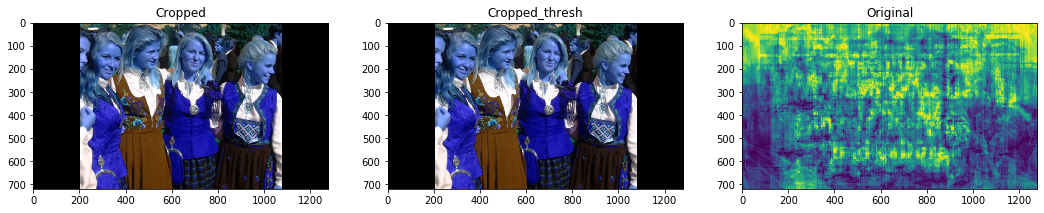

1 Running: tt9289116
Crop range: 0 720
Crop range: 0 720


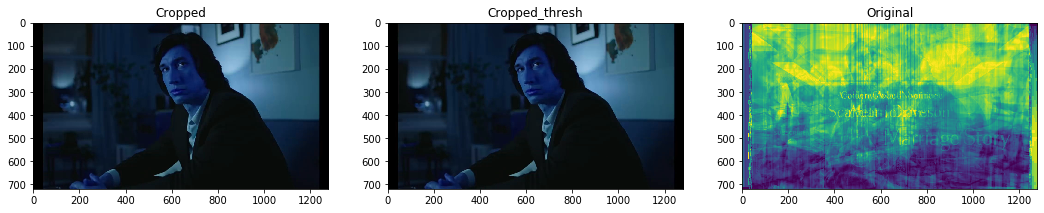

2 Running: tt8999902
Crop range: 0 360
Crop range: 11 349


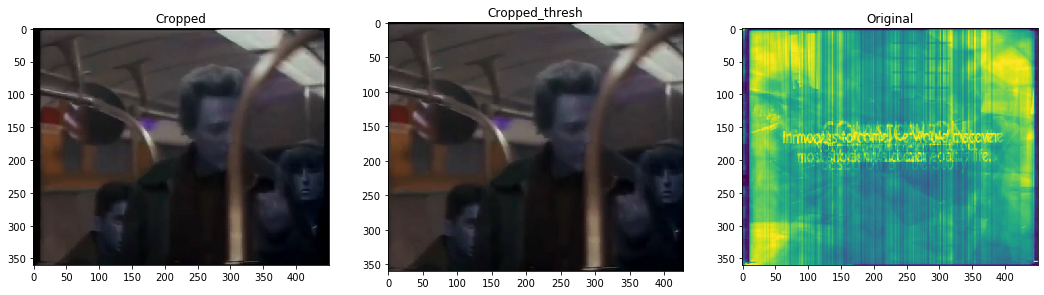

3 Running: tt8336974
Crop range: 0 720
Crop range: 0 720


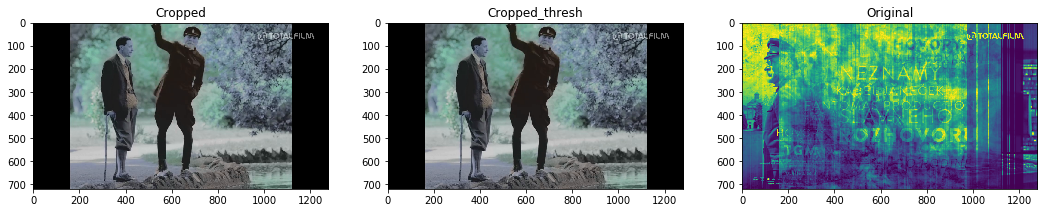

4 Running: tt8529512
Crop range: 150 570
Crop range: 156 564


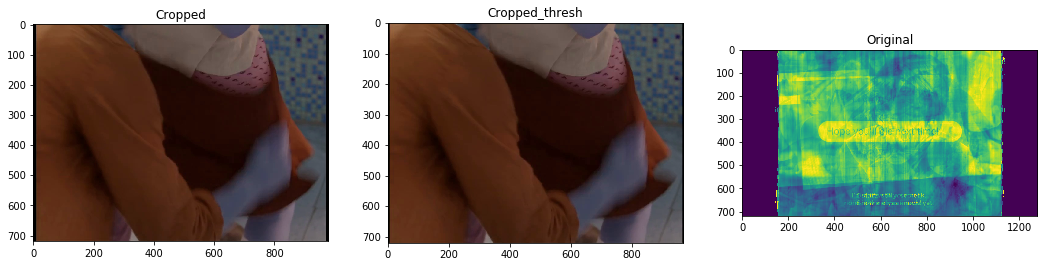

5 Running: tt8887736
Crop range: 0 720
Crop range: 0 720


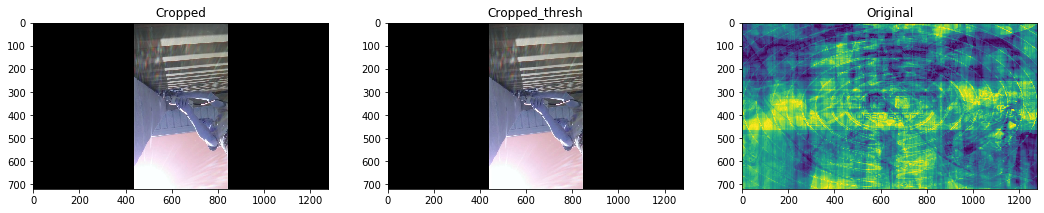

6 Running: tt7318102
Crop range: 144 576
Crop range: 156 564


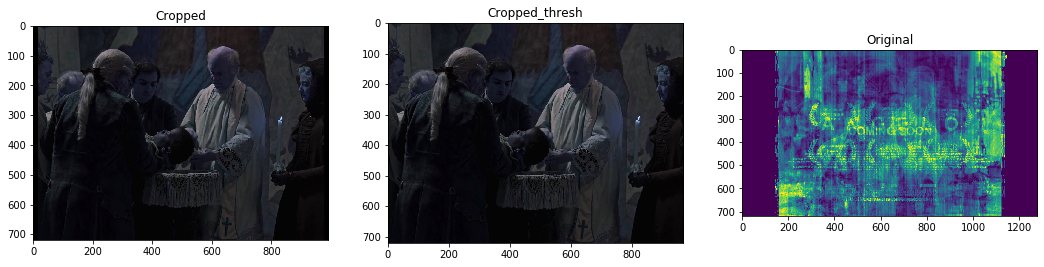

7 Running: tt8819182
Crop range: 0 720
Crop range: 0 720


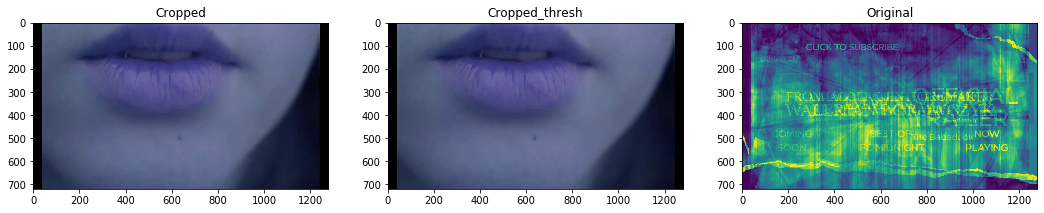

8 Running: tt8580242
Crop range: 160 560
Crop range: 160 560


9 Running: tt8386758
Crop range: 140 580
Crop range: 140 580


10 Running: tt7809816
Crop range: 96 624
Crop range: 96 624


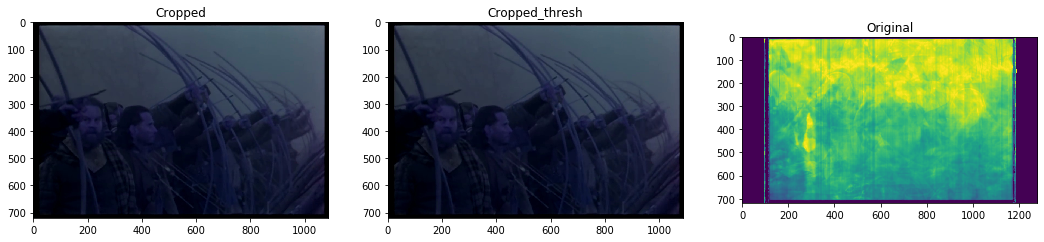

11 Running: tt7182950
Crop range: 0 720
Crop range: 0 720


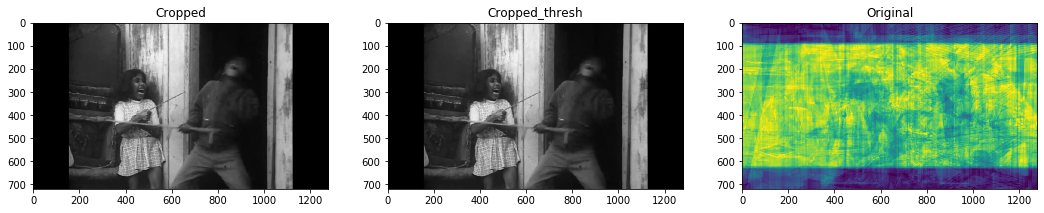

12 Running: tt6211472
Crop range: 144 576
Crop range: 144 576


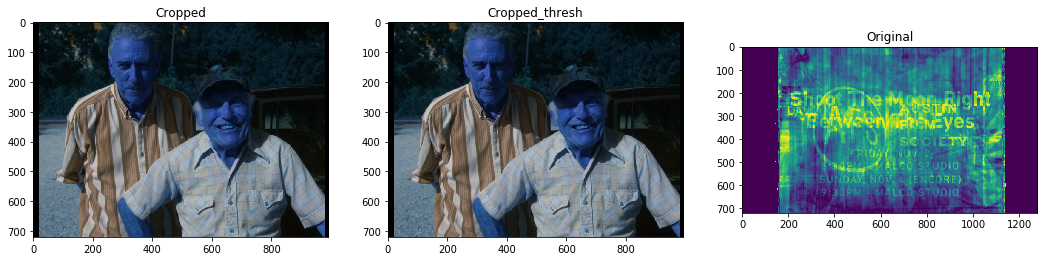

13 Running: tt9023136
Crop range: 88 632
Crop range: 88 632


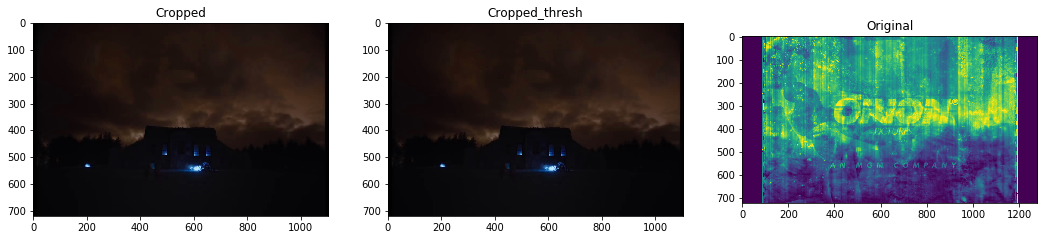

14 Running: tt7125060
Crop range: 44 676
Crop range: 44 676


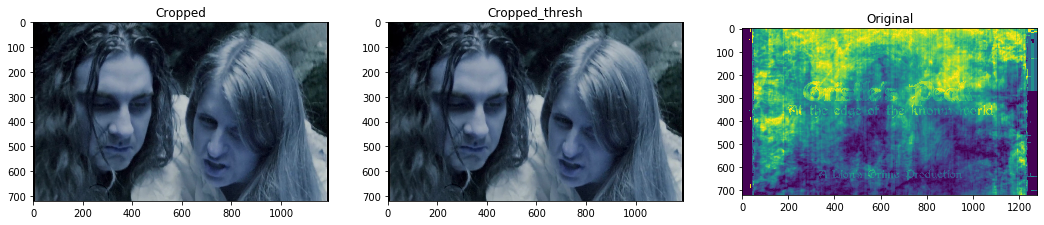

15 Running: tt9037262
Crop range: 0 720
Crop range: 0 720


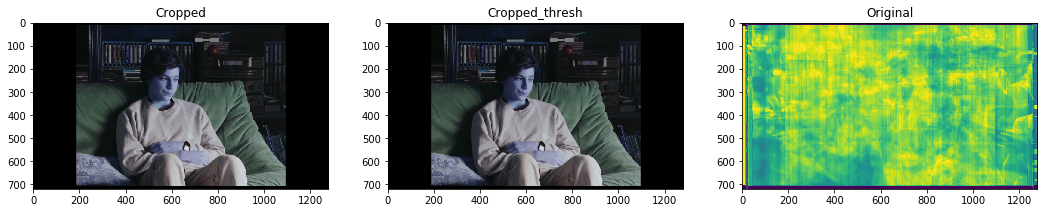

16 Running: tt8973954
Crop range: 188 532
Crop range: 186 534


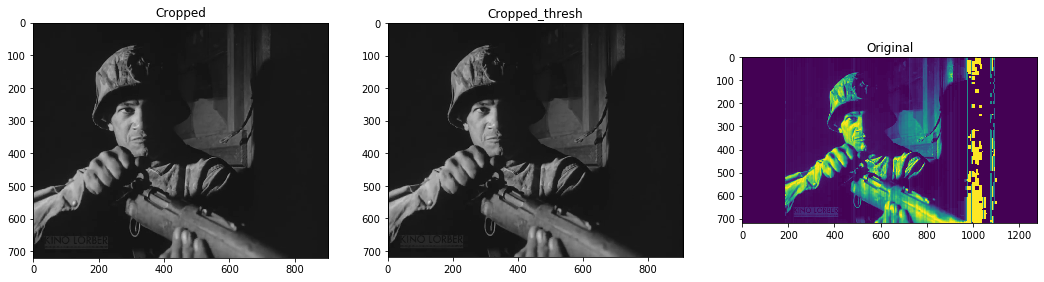

17 Running: tt9572670
Crop range: 74 286
Crop range: 73 287


18 Running: tt5960374
Crop range: 28 692
Crop range: 28 692


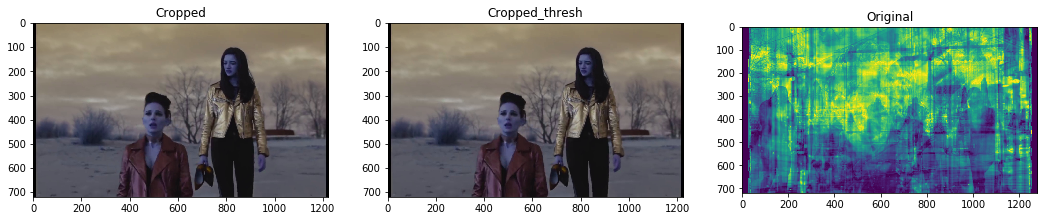

19 Running: tt9344042
Crop range: 288 388
Crop range: 288 388


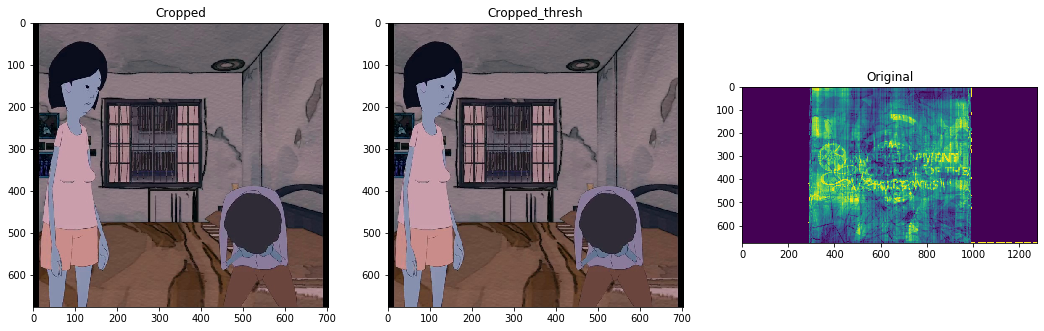

20 Running: tt4542328
Crop range: 80 640
Crop range: 80 640


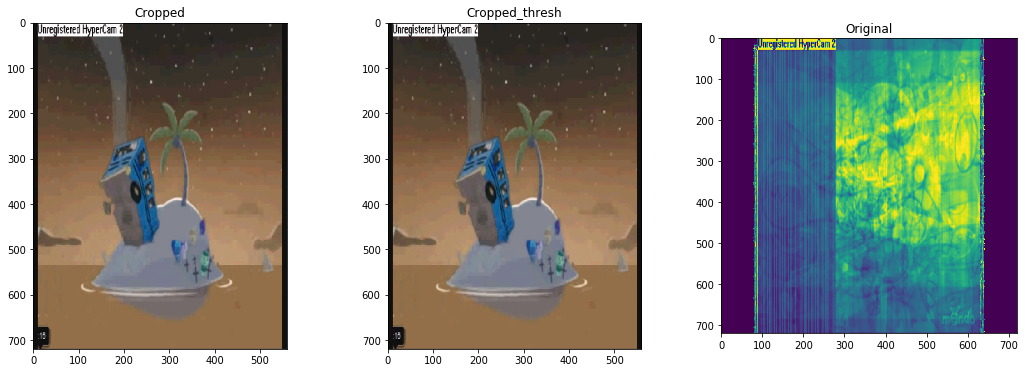

21 Running: tt8640242
Crop range: 0 720
Crop range: 0 720


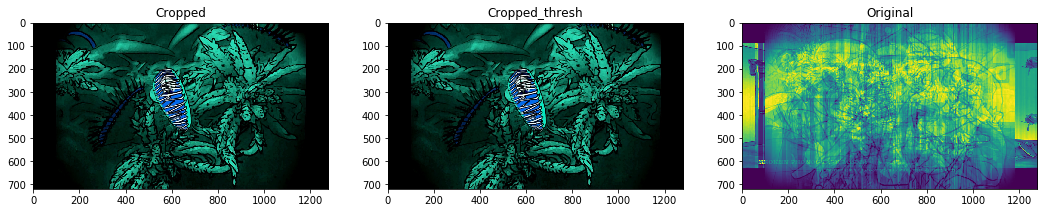

22 Running: tt3211248
Crop range: 88 632
Crop range: 88 632


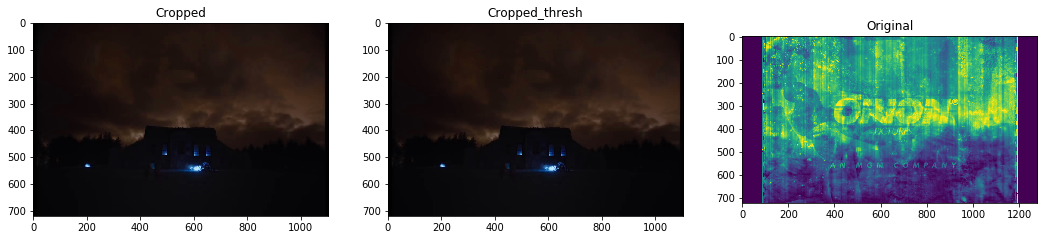

23 Running: tt7640194
Crop range: 0 720
Crop range: 0 720


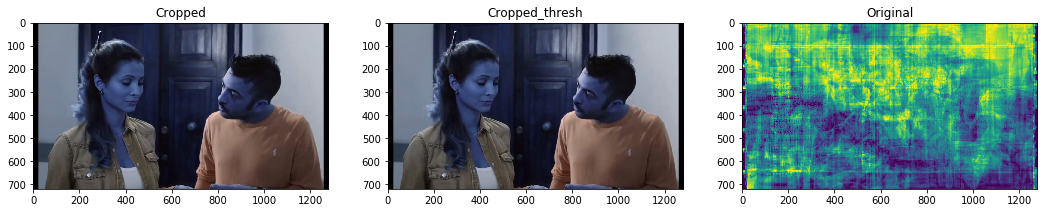

24 Running: tt4883336
Crop range: 92 628
Crop range: 92 628


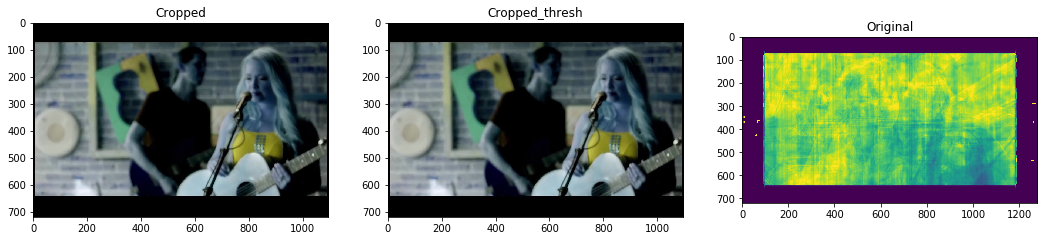

25 Running: tt8137788
Crop range: 0 720
Crop range: 0 720


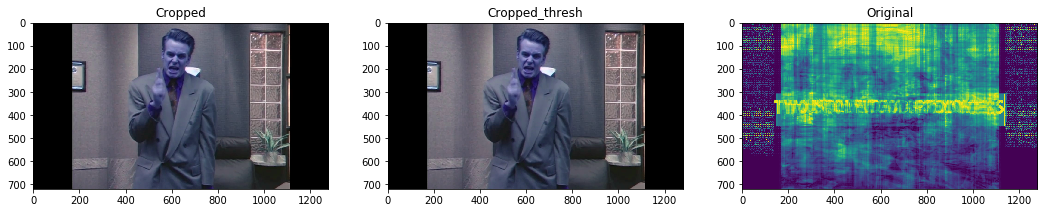

26 Running: tt8685584
Crop range: 0 360
Crop range: 0 360


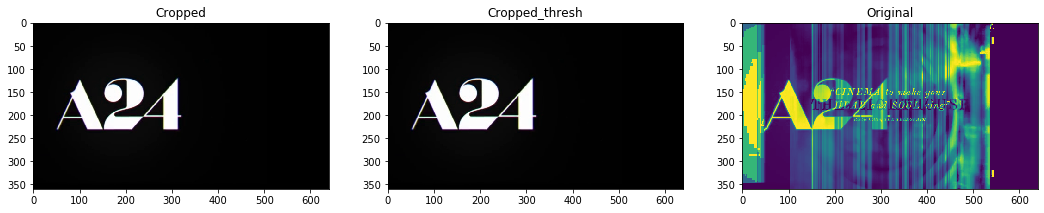

27 Running: tt8671600
Crop range: 32 688
Crop range: 32 688


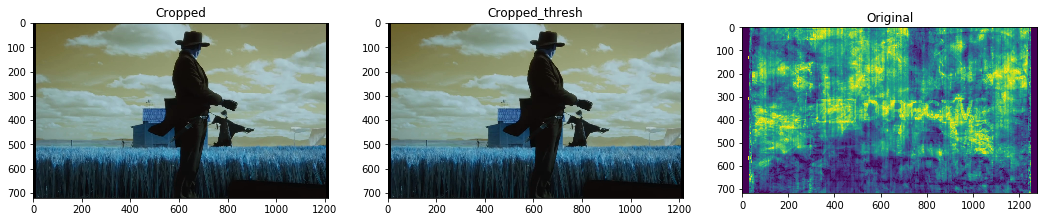

28 Running: tt8434576
Crop range: 304 416
Crop range: 304 416


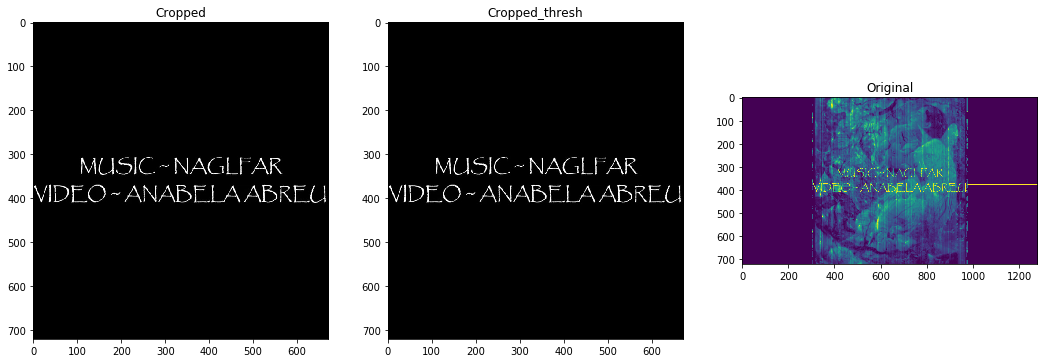

29 Running: tt6151592
Crop range: 0 720
Crop range: 0 720


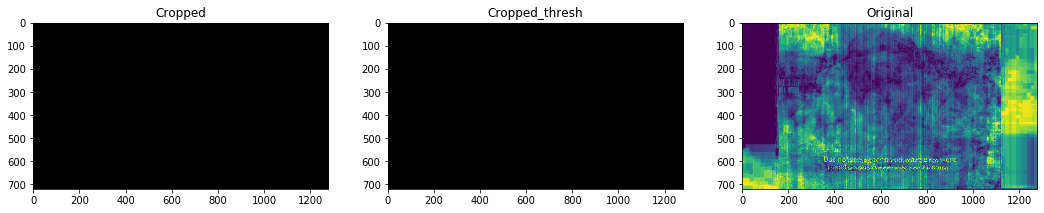

30 Running: tt9204152
Crop range: 145 575
Crop range: 145 575


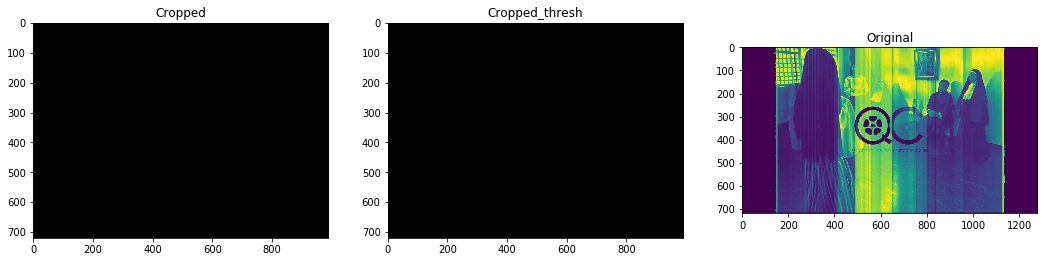

31 Running: tt4173184
Crop range: 0 720
Crop range: 0 720


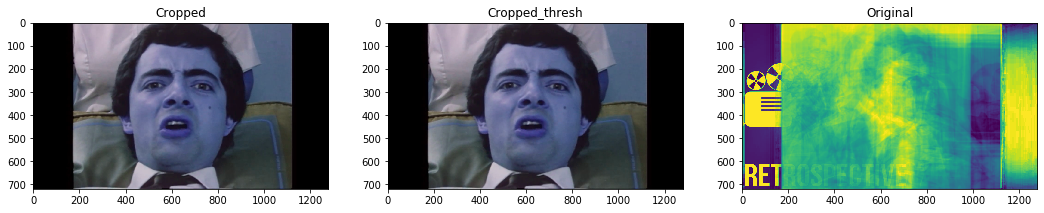

32 Running: tt8942192
Crop range: 76 284
Crop range: 76 284


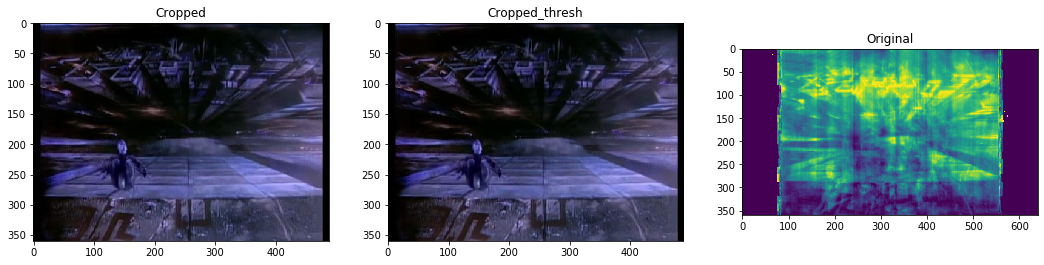

In [36]:
crop_dict = {}
count = 0
for movie in stripe:
    print(count, 'Running:', movie)
    
    # init
    li = []
    scaler = MinMaxScaler(feature_range=(0, 255), copy=True)
    
    # collect all middle frame in each scene
    for scene in os.listdir(ROOT + movie)[:20]:
        framePath = ROOT + movie + '/' + scene + '/frames/'
#         print(framePath, os.listdir(framePath))
        frameList = [int(name.split('.')[0]) for name in os.listdir(framePath)]
        frameList.sort()
#         print(frameList)
        keyframe = framePath + str(frameList[len(frameList)//2]) + '.jpg'
#         print(keyframe)
        
        # 讀取圖檔
        img = cv2.imread(keyframe)

        # 轉換至 HSV 色彩空間
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # 取出明度
        value = hsv[:,:,2]
        li.append(value)
    
    arr = np.asarray(li)
#     print(len(li), arr.shape)
    # sum up
    arr_sum = np.sum(arr, axis=0)
#     print(arr_sum.shape, 'Max:',np.max(arr_sum), 'Min:',np.min(arr_sum))
    
    # Mapping between 0 and 255
    scaler.fit(arr_sum)
    arr_norm = scaler.transform(arr_sum)
#     print(np.max(arr_norm), np.min(arr_norm))
    
    h = arr_norm.shape[0]
    w = arr_norm.shape[1]
    
    _, threshold = cv2.threshold(arr_norm, 100, 255, cv2.THRESH_BINARY)
#     print(np.unique(threshold)) # only 0 and 255
    
    nonz = nonzero(arr_norm)
    nonz_thresh = nonzero(threshold)
    
    mode = count_mode(nonz)
    mode_thresh = count_mode(nonz_thresh)
    
    print('Crop range:',mode, h - mode)
#     crop_img = img[mode: h - mode, :] # horizontal
    crop_img = img[:, mode: w - mode] # vertical
    
    print('Crop range:',mode_thresh, h - mode_thresh)
#     crop_img_thresh = img[mode_thresh: h - mode_thresh, :] # horizontal
    crop_img_thresh = img[:, mode_thresh: w - mode_thresh] # vertical
    
    plt.figure(figsize=(18,6))
    plt.subplot(131).set_title("Cropped"), plt.imshow(crop_img)
    plt.subplot(132).set_title("Cropped_thresh"), plt.imshow(crop_img_thresh)
    plt.subplot(133).set_title("Original"), plt.imshow(arr_norm)
    plt.show()
    
    # save crop dict
    crop_dict[movie] = mode_thresh
    count += 1
    print('====================================================================================================')

### Some dict problem

In [38]:
print(len(crop_dict))
print(type(crop_dict))
print(crop_dict)

33
<class 'dict'>
{'tt9635722': 0, 'tt9289116': 0, 'tt8999902': 11, 'tt8336974': 0, 'tt8529512': 156, 'tt8887736': 0, 'tt7318102': 156, 'tt8819182': 0, 'tt8580242': 160, 'tt8386758': 140, 'tt7809816': 96, 'tt7182950': 0, 'tt6211472': 144, 'tt9023136': 88, 'tt7125060': 44, 'tt9037262': 0, 'tt8973954': 186, 'tt9572670': 73, 'tt5960374': 28, 'tt9344042': 288, 'tt4542328': 80, 'tt8640242': 0, 'tt3211248': 88, 'tt7640194': 0, 'tt4883336': 92, 'tt8137788': 0, 'tt8685584': 0, 'tt8671600': 32, 'tt8434576': 304, 'tt6151592': 0, 'tt9204152': 145, 'tt4173184': 0, 'tt8942192': 76}


In [39]:
write_json(str(crop_dict), './json/crop_dict4Trailers_vertical_2018.json')

In [40]:
print(len(crop_dict))
print(type(crop_dict))
print(crop_dict)

33
<class 'dict'>
{'tt9635722': 0, 'tt9289116': 0, 'tt8999902': 11, 'tt8336974': 0, 'tt8529512': 156, 'tt8887736': 0, 'tt7318102': 156, 'tt8819182': 0, 'tt8580242': 160, 'tt8386758': 140, 'tt7809816': 96, 'tt7182950': 0, 'tt6211472': 144, 'tt9023136': 88, 'tt7125060': 44, 'tt9037262': 0, 'tt8973954': 186, 'tt9572670': 73, 'tt5960374': 28, 'tt9344042': 288, 'tt4542328': 80, 'tt8640242': 0, 'tt3211248': 88, 'tt7640194': 0, 'tt4883336': 92, 'tt8137788': 0, 'tt8685584': 0, 'tt8671600': 32, 'tt8434576': 304, 'tt6151592': 0, 'tt9204152': 145, 'tt4173184': 0, 'tt8942192': 76}
